# 2 - MNIST CNN Network

Adapted from this tutorial -> https://victorzhou.com/blog/keras-cnn-tutorial/#the-full-code

`github.com/samph4`

~

### Preface

This example will use the same MNIST dataset as we used in the last example. However, this time we are going to train a different class of neural network. This time, we'll be using a Convolutional Neural Network (CNN). CNN's are extremely popular recently as they have revolutionised the field of computer vision as they are well equipped to deal with and process data in image format. There is an article by Victor Zhou (https://victorzhou.com/blog/intro-to-cnns-part-1/) that does an excellent job introducing what a CNN is, but I'll try and summarise his key points here.

A classic use of CNNs is to perform image classification e.g. looking at an image of a pet and determining whether it is a cat or a dog. CNN's can achieve extraordinary results in this regard and some of the most successful and popular CNN networks achieve accuracies of over 88 % on famous image databases such as ImageNet that contains over 14 million images  belonging to ~22,000 categories (where one category might be a cat). You can quickly begin to appreciate the capabilities of these networks and the tasks they might be able to perform. It is a fantastic time to get into machine learning since large improvements in the field have been made in the last 10 years: the image below shows the progression of the 'state of the art' trained networks on the ImageNet database (taken from https://paperswithcode.com/sota/image-classification-on-imagenet).

![Image](./Figures/cnn_exp.png)

Determining whether or not an image is of a cat or a dog seems straight forward, couldn't we just use a standard neural network (MLP)? The answer is yes, but it might be an extremely inefficient solution. The reason being that images can be very big (depending on pixel size). 

> "Images used for Computer Vision problems nowadays are often 224x224 or larger. Imagine building a neural network to process 224x224 color images: including the 3 color channels (RGB) in the image, that comes out to 224 x 224 x 3 = 150,528 input features! A typical hidden layer in such a network might have 1024 nodes, so we’d have to train 150,528 x 1024 = 150+ million weights for the first layer alone. Our network would be huge and nearly impossible to train." - https://victorzhou.com/blog/intro-to-cnns-part-1/.

This is exactly what we did in the previous example, where we took the 28x28 input image (MNIST digit) and flattened it to form a feature vector of 784 elements. This quickly gets out of hand with larger image sizes and as a result training times and convergence can suffer. Nor is it the most logical approach. Intuitively, when we consider an image we interpret the image based on a collection of pixels. Pixels are most useful in the context of their neighbours and as humans we gather much more information from a collection of pixels rather than isolated, indivudal colours. Objects in images are made up of small, *localised* features, like the circular iris of an eye or the square corner of a piece of paper. Doesn't it seem wasteful for every node in the first hidden layer to look at every single pixel? Could it therefore be helpful to try and create something that adopts similar practicices? Also, positions can change. And this is particularly important. If we train a network that is capable of identifying a cat, we would want the model to be able to detect that cat regardless of where it appears in the image.

> "Imagine training a network that works well on a certain dog image, but then feeding it a slightly shifted version of the same image. The dog would not activate the same neurons, so the network would react completely differently!". - https://victorzhou.com/blog/intro-to-cnns-part-1/.

We did not run into this problem in the previous example since the MNIST dataset had been structured for us. The dataset contains small images (low # of pixels = low # of features) that, more imporantly, had been centered so we did not encounter the issue of shifting or funky orientations.

### What are CNNs?

To get a good overview of what happens within a Convolutional Neural Network, I would strongly reccomend to watch this video first (https://www.youtube.com/watch?v=YRhxdVk_sIs). It is a relatively short video but does a good job explaining the concept and highlights some of the key points to be aware of - watching it will make the rest of this example make a lot more sense.

![Image](./Figures/cnn.jpeg)

#### Feature Learning
The diagram above shows a typical schematic for a CNN. You can see that the process is split into two main categories; feature learning and classification. Let us first consider feature learning:

> Feature learning is a set of techniques that learn a feature: a transformation of raw data input to a representation that can be effectively exploited in machine learning tasks. - https://www.quora.com/What-is-feature-learning.

In that regard, we will create the CNN architecture such that it can learn the features of the problem. You'll notice on the diagram above that within the feature engineering categories there are different actions happening that we can take advantage when performing feature engineering. Of course, the input in this case is self explanatory as we know that we are dealing with an input of image format. But the others include convolutions, activation functions and pooling. 

<ins>Convolution</ins>

Convolutional layers in a CNN systematically apply learned filters to input images in order to create feature maps that summarize the presence of those features in the input. Convolutional layers prove very effective, and stacking convolutional layers close to the input to learn low-level features (lines) and layers deeper in the model to learn high-order features or more abstract features, like shapes or specific objects.
```{note}
It is important to emphasise here that in the video they will have mentioned filters such as the 'edge detection filters' that you can convolve across an image to detect the edges. The difference is, during training the CNN network creates their OWN filters and optimises them to learn features specific to the problem and subsequently improve the loss function.
```

<ins>Pooling</ins>

A pooling layer is a new layer added after the convolutional layer. Specifically, after a nonlinearity (e.g. Relu) has been applied to the feature maps output by a convolutional layer; for example the layers in a model may look as follows:

1. Input image
2. Convolutional layer
3. Activation Function (non-linearity)
4. Pooling Layer

The pooling layer is important because it helps to make the feature representation become approximately invariant to small translations in the input. We mentioned earlier that one of the issues with a MLP network with a large input vector would be that if there were changes in position (translations/rotations) of the object you are trying to classify, then the model would struggle to recognise/classify the object as you would expect. Here, the pooling layer operates upon each feature map separately to create a new set of the same number of pooled feature maps (feature map = output from Conv layer, often there are a few maps due to 3 RGB channels etc). Pooling involves selecting a pooling operation, much like a filter, to be applied to the feature maps in a similar fashion to convolving. The size of the pooling operation or filter is smaller than the size of the feature map, typically it is almost always 2x2 pixels. 

This means that the pooling layer will always reduce the size of each feature map by a factor of 2, e.g. each dimension is halved, reducing the number of pixels or values in each feature map to 1/4 of the size. For example, a pooling layer applied to a feature map of 6x6 (36 pixels) will result in an output pooled feature map of 3x3 (9 pixels). 

> "In all cases, pooling helps to make the representation become approximately invariant to small translations of the input. Invariance to translation means that if we translate the input by a small amount, the values of most of the pooled outputs do not change." - Page 342, Deep Learning, Ian Goodfellow 2016

The pooling operation is specified and is not a learnable parameter. Two common functions used in the pooling operation are: Average pooling and Maximum pooling. Average pooling calculates the average value for each patch on the feature map, whereas maximum pooling calculates the maxmimum value for each patch on the feature map (patch refers to the 2x2 pooling filter applied to the feature map output by the Conv Layer). The result of using a pooling layer and creating down sampled or pooled feature maps is a summarized version of the features detected in the input.

#### Classification

The classification segment is almost identical to the MLP segment in the previous example. We begin by flattening the output of the final pooling layer to form a single vector; so if the final output layer is of size [16x16], we flatten this such that it becomes a vector of 256 elements. Depending on the problem, we may wish to pass this feature vector through an additional dense (fully-connected) layer which is a standard MLP layer with a user-defined number of nodes. Finally, we add a softmax layer to convert the output of the final layer in the network to a probability distribution consisting of a prediction by the model for each of the classes defined in the training dataset.

~

### Creating the CNN Algorithm

#### Necessary Imports

Like we did last time, we begin by importing the packages that we will use to develop our algorithm. `Numpy` is a python library used for working with arrays and the syntax is very similar to MATLAB which makes manipulating data easy. Again, we use the `keras` library because it gives us access to machine learning functions without us having to code them all explicitly. Last time, we imported the mnist dataset through the `keras.datasets` attribute, but here we import the data directly from `mnist` by calling `import mnist`. This can be useful because you can get access to more information about the dataset. Often we must use a particular version of keras for compatibility issues and as such might not have the most up to date information (if anything has been added since that update). Finally, we call `matplotlib` again to make our plots.

In [1]:
import numpy as np 
from tensorflow import keras 
import mnist # import mnist directly to access more info
import matplotlib.pyplot as plt

# layers used in CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

# convert scalar labels to categorical
from tensorflow.keras.utils import to_categorical

#### Loading & Preparing the training data

Here we define the variables that contain the training and test data from the mnist dataset. If unsure about the structure of the mnist import, we can call `dir(mnist)` and we will see a whole list of attributes that we can call. Here we see that `train_images` and `test_images` has already been prepared as part of the import, so we can simply make a variable equal to `mnist.train_images()` to store the training images. It is a similar story with the labels; we can call `mnist.train_labels()` to obtain the labels for the training data. The first element here will show the class for the first image in the training set.

```{tip}
Always check the shape of the dataset whenever you import one! Will make it much easier to create your model architecture and avoid any incompatibilities.
```

In [2]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()
test_images = mnist.test_images()
test_labels = mnist.test_labels()

print(train_images.shape) # (60000, 28, 28)
print(train_labels.shape) # (60000,)

(60000, 28, 28)
(60000,)


Before we begin, we’ll normalize the image pixel values from [0, 255] to [-0.5, 0.5] to make our network easier to train (using smaller, centered values usually leads to better results). We’ll also reshape each image from (28, 28) to (28, 28, 1) because Keras requires the third dimension to also be specified.

In [3]:
# Normalize the images.
train_images = (train_images / 255) - 0.5
test_images = (test_images / 255) - 0.5

# # Reshape the images.
train_images = np.expand_dims(train_images, axis=3)
test_images = np.expand_dims(test_images, axis=3)

print(train_images.shape) # (60000, 28, 28, 1)
print(test_images.shape)  # (10000, 28, 28, 1)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


#### Creating the CNN 

Convolutional Neural Networks do not learn a single filter. Infact, they learn multiple features in parallel for a given input. The amount of filters you would want the CNN to learn depends on the complexity of the problem. For example, if you are trying to develop a CNN classification network that can tell the difference between a dog and a whale; you would not need many filters at all as the features of dogs and whales are so vastly different and it is 'easier' to differentiate between the features of the animals. Differentiating between dog breeds however may be more difficult, each dog breed has 4 legs, fur, two eyes and a nose etc - but the differences between breeds may be more subtle and dependent on the proportions of the face and body etc. We would therefore require more filters in the CNN such that the model has more opportunity to create filters that 'learn' how to identify key features that differentiate between the different breeds (classes).

Here we set the number of filters to be 8, filter size as 3 and the pool size as 2. As mentioned earlier, a filter is a [NxN] array that convolves over the image/feature map. So the filter size of 3 refers to a [3x3] filter and thus this refers to 9 additional trainable parameters to optimize during training. The pool size is set at 2 which refers to a [2x2] pooling operation (filter).

In [4]:
num_filters = 8
filter_size = 3
pool_size = 2

We can use the `set()` function which is a default Python function to determine each of the unique classes in this dataset. The ` set()`  function allows us to input a list/vector within its parentheses and returns a set of unique values from the input. Therefore if we write ` set(train_labels)`:

In [5]:
set(train_labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

We see each of the possible classes for the MNIST dataset. Intuitively this also makes sense because 0-9 are the only numeric digits that exist. We can then call the ` len()`  function to determine the length of this set, i.e. the total number of classes.

In [6]:
num_classes = len(set(train_labels))
print(f'Total number of classes:',num_classes)

Total number of classes: 10


Here we will actually start to define the architecture of the CNN network. Again this part shouldn't be scary, the most import thing (as always), is making sure that we have a clear idea as to what is going into the network (input) and what is going out of it (the output). We previously formatted the training data such that the input image has a shape (28,28,1) as Keras requires the input to have three dimensions. We want the model to take an image as input and give us the classification vector as output. We know that we cant the output to be a probability distribution associated with a prediction for any given input that corresponds to one of the 10 different classes we are classifying.

In [7]:
model = Sequential()

model.add(Conv2D(num_filters, filter_size, input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

The structure here should be familiar and share some similarities with the MLP network that we made in the previous example. Again, we create a `Sequential()` model. This allows us to define a model architecture layer by layer, adding subsequent layers easily by using the `model.add()` attribute in Keras. We then proceed to add four layers; a `Conv2D` layer, a `MaxPooling2D` layer, a `Flatten` layer and finally a `Dense` (fully connected) layer.

The Conv2D class is structured as follows:

`Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None, **kwargs)`.

Note that any parameter with an equals sign is a default property that can be modified if we require further modification of the convolution layer. The `filters` property refers to the number of filters, in our case equal to variable `num_filters` that we previously defined as 8. The `kernel_size` property refers to the dimension of the filter themselves (also known as kernels) for which we already defined variable `filter_size` as 3. Finally we must define the shape of the input as this is the first layer in the network, here the images are [28x28] pixels in size and we recall that keras required the input to be in a format with the third dimension present.

We add the pooling layer simply by calling `model.add(MaxPooling2D())` and we must define the size of the 'pooling' filter/kernel, which we previously defined as `pool_size` with a value of 2. We then flatten the feature map into a single (1D) vector of nodes (such that a 28x28 would become a vector of 784 elements). Finally, we connect this to a `Dense()` (fully connected) layer with a softmax activation function (to return probability distribution) for the defined number of classes `num_classes`.

The last step before training is to compile the model. We need to compile the model as this lets us define the loss function, the optimizer and the metrics used to track the results of the training process. The `model.compile()` function is powerful and allows us to change and define lots of things about the training process; here we can select whichever loss function we like, we can use any optimiser and also use any metric we wish to judge the performance of the model (see https://keras.io/api/metrics/).

Refer to the previous example for more information regarding this, but again we select the `adam` optimizer and the `categorical_crossentropy` function and wish to record the `accuracy` metrics to evaluate the training process.

In [8]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [9]:
num_epochs = 10
model.fit(train_images,to_categorical(train_labels, num_classes), epochs=num_epochs,validation_data=(test_images, to_categorical(test_labels, num_classes)))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10


   32/60000 [..............................] - ETA: 13:37:31

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential/conv2d/Conv2D (defined at <ipython-input-9-302e094c995d>:2) ]] [Op:__inference_distributed_function_695]

Function call stack:
distributed_function


### Results and Evaluation

Now the model has been trained and we can evaluate the results and play around with the trained model. I mentioned in the previous example that the metrics during trained are saved within the model variable itself, and we can access the data by calling `model.history.history`. The data is stored here in a dictionary format. Calling `model.history.history` prints out the contents and we can see the metrics that have been stored, we see `loss`, `accuracy`, `val_loss` etc and access that data explicitly by using square brackets and indexing the string containing the data we want. So if we want to create a new variable containing all of the computed `loss` values during training. We can write `loss = model.history.history['loss']` and use that data to perform further analysis. In this case, we are just going to plot the data to see what is happening during training.

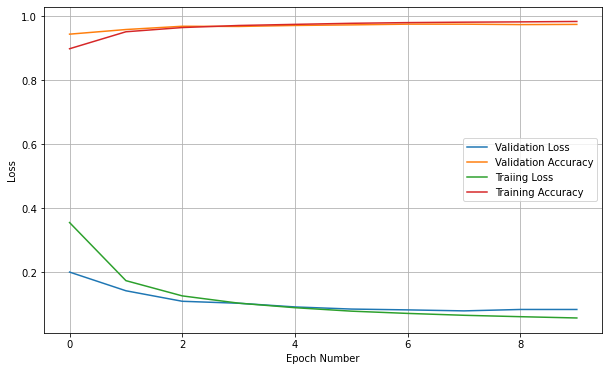

In [10]:
plt.figure(figsize=(10,6))
plt.plot(range(num_epochs),model.history.history['val_loss'], label='Validation Loss')
plt.plot(range(num_epochs),model.history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(range(num_epochs),model.history.history['loss'], label='Traiing Loss')
plt.plot(range(num_epochs),model.history.history['accuracy'], label='Training Accuracy')

# some simple formatting
plt.legend()
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.grid('True')
plt.show()

As you can see, training loss decreases rapidly (noted by the steep gradient). This is perfectly normal, as the model always learns most during the early stages of optimization. Accuracies converge after only one epoch, and still improve during the 10th, albeit slightly. Validation loss begins to convergeat around the 6th epoch. This means that training the model for longer (increasing the number of epochs) is unlikely to improve the accuracy of the model. 


```{tip}
 Often when models are unsuccessful, some clues as to what went wrong can appear when plotting this information. We can therefore go back and make changes to the model architecture or training parameters and try again. 
```

#### Test the model using the test data

However, this was all observed from validation data. What’s best is to test it with the actual testing data that was generated earlier. Here we call the `model.evaluate` function and input the test data we created earlier, `test_images` and `test_labels` - remembering to convert the test labels into `to_categorical` format as we are using the `categorical_crossentropy` loss function. Once again we can use the verbose feature to display the progress output and print the results.

In [11]:
# Test the model after training
test_results = model.evaluate(test_images, to_categorical(test_labels, num_classes), verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

10000/10000 [==============================] - 1s 61us/sample - loss: 0.0829 - accuracy: 0.9738
Test results - Loss: 0.0829402305746451 - Accuracy: 97.3800003528595%


The results show that the accuracy of the model was 97.79 % when evaluated on the test data that it had not been trained on! This is obviously a good result especially given the simplicity of the network and the short amount of time spent training. We could modify size of the network by increasing the number of filters, modify the size of the filters, play around with pooling, use different optimisers, activation functions and loss functions in attempt to improve the accuracy of the network. We already established that training the model for longer is unlikely to yield better results as the network has began to converge.

Once again, let's play around with the model that we just trained and take a look at how we can use it to make new predictions. First of all, we call the `model.predict()` function to use the model (as you might expect) to make a new prediction. The code below selects an image from the test set by defining an index and plots a bar chart that corresponds to the probability distribution produced by the softmax output. The predictions in this layer correspond to the confidence that the trained CNN believes that the input belongs to a particular class.

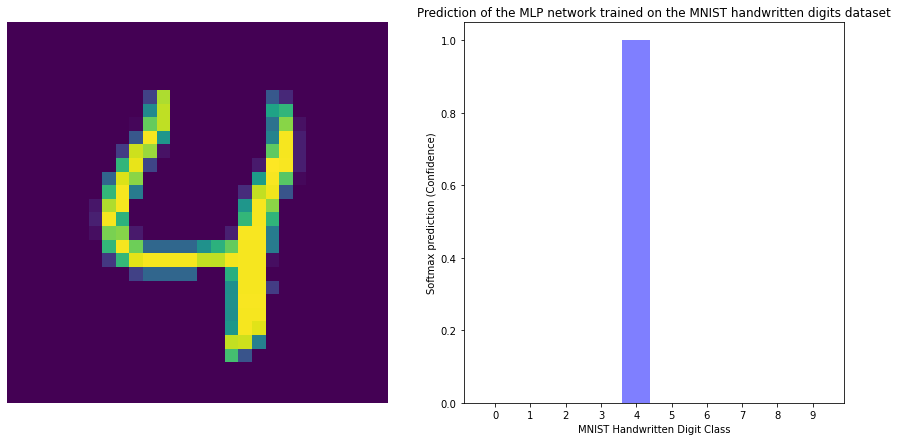

In [12]:
# create subplot to show input and its prediction
plt.figure(figsize=(15,7))

index = 4
test_input = test_images[index,:,:]


# MNIST test input (1st subplot)
plt.subplot(1,2,1)
plt.imshow(test_input.reshape(28,28))
plt.axis('off')

# bar chart (2nd subplot)
plt.subplot(1,2,2)
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
# prepare input to cnn
cnn_test_input = test_images[index]
cnn_test_input = cnn_test_input.reshape(1,28,28,1)
prediction = model.predict(cnn_test_input)
prediction = prediction[0,:].tolist() # convert prediction array into list to plot on chart

plt.bar(class_names, prediction, align='center', alpha=0.5, color='blue')
plt.xticks(class_names, class_names)
plt.xlabel('MNIST Handwritten Digit Class')
plt.ylabel('Softmax prediction (Confidence)')
plt.title('Prediction of the MLP network trained on the MNIST handwritten digits dataset')

plt.show()

There we have it, a trained CNN that can classify handwritten digits! If you want to take it a little further, there is more information below that looks into what is happening with the filters in more detail. 

~ Sam

### Extra: Deep dive into the filters

When I first started developing networks, I wish that more of the tutorials that I learnt from showed you how to access the data that the model has learned so that you can see and interact with the learned parameters. So I'm going to show you a few additional things that you can do to understand your model better. First of all, we can call the `model.summary()` function to print out the architecture of the network.

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1352)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                13530     
Total params: 13,610
Trainable params: 13,610
Non-trainable params: 0
_________________________________________________________________


Here you can see each of the layers clearly and the total number of trainable parameters. In the first `Conv2D` layer, we can see that the shape is [26x26] with 8 total filters that we defined earlier. The total number of parameters is 80 which is determined by the 9 trainable parameters within each [3x3] filter multiplied by the total number of filters (8) equalling 72 (8x9). There is also an additional trainable parameter associated with each filter known as the bias, therefore total parameters = 72 + 8 = 80. During training, these values are optimised to reduce the loss function and subsequently imporve the accuracy of the network. 

In [20]:
model.layers

We can call the `model.layers` function to access the data stored within each layer within the model. This prints out four layers corresponding to the `Conv2D` layer (index 0) and the `MaxPooling2D` layer (index 1) etc. From here, we can call `dir(models.layers[0])` to see all of the attributes that we can call from the `Conv2D` layer. The `get_weights()` attribute allows us to access all of the optimised values i.e. the filters and the biases. We can call `filters, biases = model.layers[0].get_weights()` to create two new variables `filters` and `weights` which contain the relevant data.

In [14]:
# retrieve weights from the second hidden layer
filters, biases = model.layers[0].get_weights()

As always, we should double check the structure of the new `filters` variable by calling `filters.shape`.

In [15]:
filters.shape

(3, 3, 1, 8)

We can see the shape of the `fitlers` variable is (3,3,1,8). This refers to the size of the filter (which is [3x3x1]) and the total number of filters (8), hence (3,3,1,8). We can print the filter values for the first array (index 0) by calling `filters[:,:,:,0]`. 

In [16]:
filters[:,:,:,0]

array([[[ 0.06931005],
        [ 0.36179632],
        [ 0.28139392]],

       [[-0.83887345],
        [ 0.41776526],
        [ 0.30940893]],

       [[-0.47847265],
        [ 0.12772204],
        [ 0.46879828]]], dtype=float32)

```{note}
Remember that the : sign is used to index all elements within that particular dimension of a variable. So here we wish to access all of the filter information for the first layer of eight (index 0).
```

#### Visualising Filters

Right now each of our 8 filters exists as a [3x3] array which doesn't mean all that much. Here we use different methods to visualise the filters a better/more intuitive way. First we can create a grayscale colour map for each filter that is scaled such that the position of the largest value in the [3x3] array is black and the lowest value is white. The code below plots a subplot performing this operation for each of the eight filters.

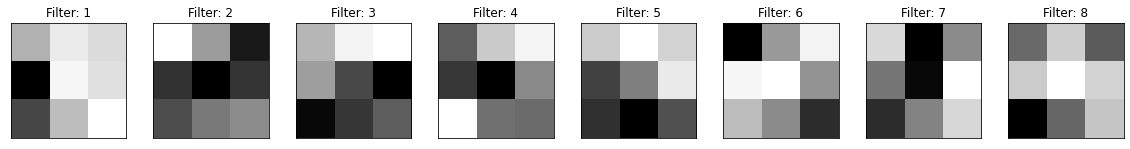

In [17]:
# create subplot to show input and its prediction
plt.figure(figsize=(20,20))
# plot first few filters
n_filters, ix = 8, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(1):
        # specify subplot and turn of axis
        ax = plt.subplot(n_filters, 8, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='gray')
        ix += 1
        plt.title('Filter: ' + str(i+1))
# show the figure
plt.show()

The dark squares indicate small or inhibitory weights and the light squares represent large or excitatory weights. Using this intuition, we can see that Filter #5 on the first row has strong horizontal presence - this suggests that the filter might be suitable to detecting horizontal edges. 

#### Visualising Feature Maps

Lets apply each of these filters directly to some of the MNIST digits and see what effect they have and visualise what the feature maps (output from CNN layer) within the network might look like. We import the `cv2` library here to allow us to perform 2D convolutions by calling the attribute `cv2.filter2D()` - inside the parentheses we can define the image we wish to convolve over and the filter that we wish to use. Aside from that, we are once again utilising `matplotlib` to allow us to make a subplot with multiple graphs. In this example we take the first 8 images from the test dataset (to create the rows) and apply each of the 8 filters that we trained from the 2D network to them.

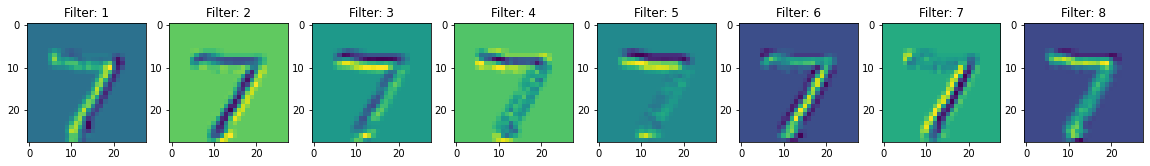

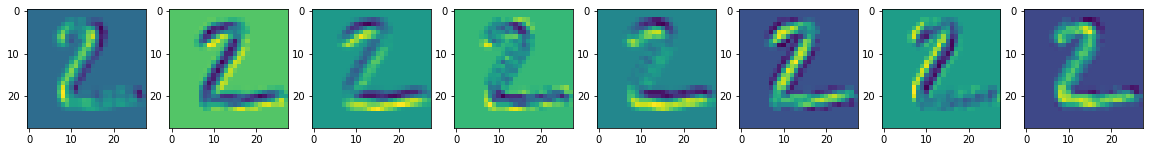

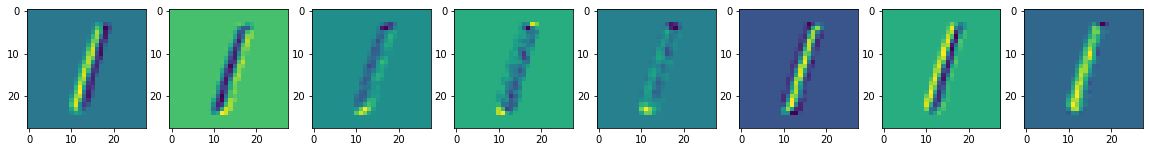

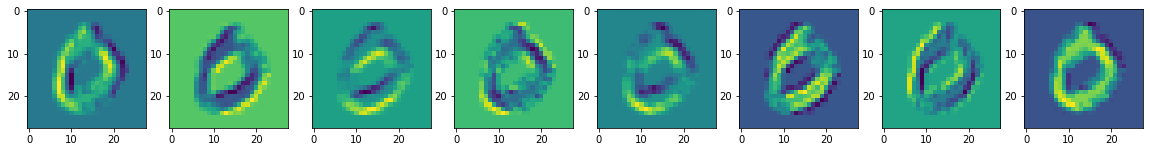

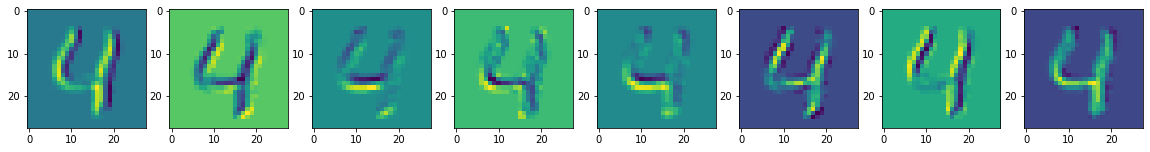

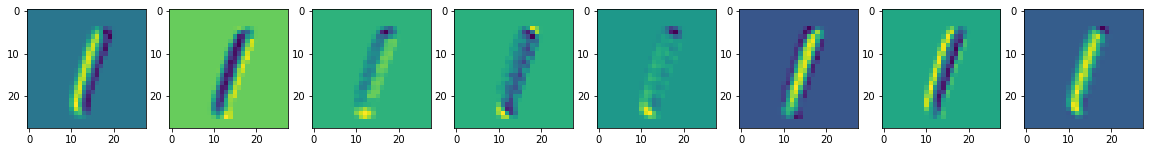

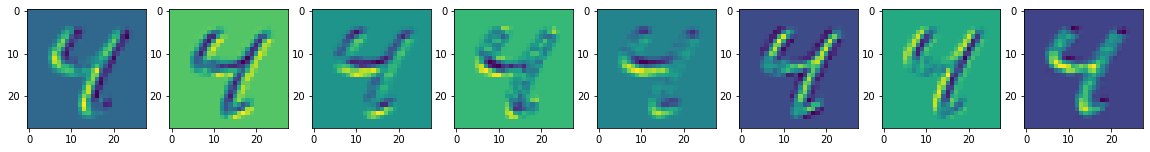

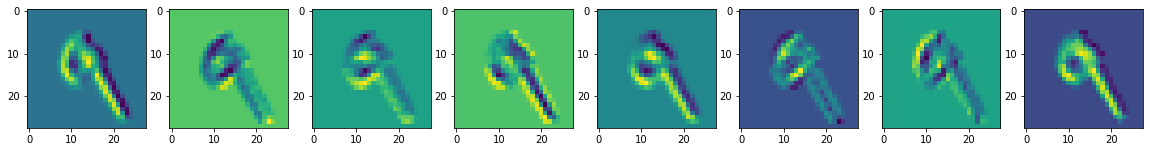

In [18]:
import cv2 

nf = 8 # number of filters
nr = 8 # number of test images

for j in range(nr):
    plt.figure(figsize=(20,10))
    for i in range(nf):
        
        plt.subplot(1,nf,i+1)
        image = test_images[j]
        result = cv2.filter2D(image, -1, filters[:,:,:,i])
        plt.imshow(result.reshape(28,28))
        
        if j==0:
            plt.title('Filter: ' + str(i+1))
        else:
            continue

    plt.show()

This is a useful task to do as it gives us a much clearer indication as to what the filters are actually doing. We mentioned before that Filter #5 could be a horizontal edge detection filter, and we can see that this is actually the case as the horizontal lines that exist in the MNIST digit image are emphasised and dark. 

Another useful task might be to take a single input image and sequentially apply each of the 8 filters to give a true representation as to what is happening inside the CNN network. In this example, we just applied each filter to the original MNIST image. It should be emphasised at this point that the initial filters of a CNN network tend to detect larger/more distinct features from the input image, and as you progress deeper into the CNN network the filters tend to detect more subtle differences. This is more obvious for more sophisticated CNNs that have more sophisticated filters that are able to identify a more complex variety of features.